In [3]:
import pandas as pd
import numpy as np
import os
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Read in LGM C and O Data 
folder_path = "Data/merged_files_intcal20"
file_list = os.listdir(folder_path)
csv_files = [file for file in file_list if file.endswith(".csv")]

LGM_CO_df = pd.concat([pd.read_csv(os.path.join(folder_path, file)) for file in csv_files], ignore_index=True)

LGM_CO_df.to_csv('LGM_CO_df.csv', index=False)


# LGM Nd Data
file_path = "Data/Du2020.xlsx"
Du2020_df = pd.read_excel(file_path, sheet_name="Holocene and LGM")

file_path = "Data/Howe2016.xlsx"
Howe2016_df = pd.read_excel(file_path)

LGM_Nd_df = pd.concat([Du2020_df, Howe2016_df], ignore_index=True)
LGM_Nd_df = LGM_Nd_df[['Latitude', 'Longitude', 'Depth_m', 'epsilon_Nd_LGM']].copy().rename(columns={'Latitude': 'lat', 'Longitude': 'lon', 'Depth_m': 'depth', 'epsilon_Nd_LGM': 'e_Nd'}).dropna(inplace=False)

LGM_CO_df = LGM_CO_df[['Latitude (degN)', 'Longitude (degE)', 'Site Depth (m)', 'd13C (PDB)', 'd18O (PDB)']].copy().rename(columns={'Latitude (degN)': 'lat', 'Longitude (degE)': 'lon', 'Site Depth (m)': 'depth', 'd13C (PDB)': 'd13C', 'd18O (PDB)': 'd18O'}).dropna(inplace=False)

# Define bin sizes
lat_bin_size = 5
lon_bin_size = 5
depth_bin_size = 100

# Create bins for latitude, longitude, and depth in both dataframes
LGM_CO_df['lat_bin'] = pd.cut(LGM_CO_df['lat'], np.arange(-90, 90+lat_bin_size, lat_bin_size))
LGM_CO_df['lon_bin'] = pd.cut(LGM_CO_df['lon'], np.arange(-180, 180+lon_bin_size, lon_bin_size))
LGM_CO_df['depth_bin'] = pd.cut(LGM_CO_df['depth'], np.arange(0, LGM_CO_df['depth'].max()+depth_bin_size, depth_bin_size))

LGM_Nd_df['lat_bin'] = pd.cut(LGM_Nd_df['lat'], np.arange(-90, 90+lat_bin_size, lat_bin_size))
LGM_Nd_df['lon_bin'] = pd.cut(LGM_Nd_df['lon'], np.arange(-180, 180+lon_bin_size, lon_bin_size))
LGM_Nd_df['depth_bin'] = pd.cut(LGM_Nd_df['depth'], np.arange(0, LGM_Nd_df['depth'].max()+depth_bin_size, depth_bin_size))

# Merge the dataframes on the bins
LGM_df = pd.merge(LGM_CO_df, LGM_Nd_df, on=['lat_bin', 'lon_bin', 'depth_bin'])

# Drop the bin columns
LGM_df.drop(['lat_bin', 'lon_bin', 'depth_bin'], axis=1, inplace=True)
LGM_df = LGM_df.rename(columns={'lon_x': 'lon', 'lat_x': 'lat', 'depth_x': 'depth'})

LGM_df.shape


(2476, 9)

In [94]:
## Modern Data

# GLODAP data
file_path = "/Users/paigewise/Downloads/data_from_GLODAPv2.2023 2.txt"
df = pd.read_csv(file_path, delimiter='\t').dropna(inplace=False)
modern_df = df[['Latitude [degrees_north]','Longitude [degrees_east]', 'DEPTH [M]', 'DELC13 [/MILLE]', 'O18/O16 [/MILLE]']].copy().rename(columns={'Latitude [degrees_north]': 'lat','Longitude [degrees_east]': 'lon', 'DEPTH [M]': 'depth', 'DELC13 [/MILLE]': 'd13C', 'O18/O16 [/MILLE]': 'd18O'})

modern_df = df[['Latitude [degrees_north]','Longitude [degrees_east]', 'DEPTH [M]', 'DELC13 [/MILLE]']].copy().rename(columns={'Latitude [degrees_north]': 'lat','Longitude [degrees_east]': 'lon', 'DEPTH [M]': 'depth', 'DELC13 [/MILLE]': 'd13C'})

modern_df['lat'] = modern_df['lat'].round(0)
modern_df['lon'] = modern_df['lon'].round(0)
modern_df['depth'] = modern_df['depth'].round(0)
modern_df['lon'] = modern_df['lon'].apply(lambda x: x - 360 if x > 180 else x)
modern_df.dropna(inplace=True)

# GNOM model output
file_path ="/Users/paigewise/Library/CloudStorage/OneDrive-UniversityofSouthernCalifornia/Documents/Spring_2024/Env_Data_Science_/final_project/Data/GNOM.csv"
GNOM_df = pd.read_csv(file_path)
GNOM_df['lat'] = GNOM_df['lat'].round(0)
GNOM_df['lon'] = GNOM_df['lon'].round(0).apply(lambda x: x - 360 if x > 180 else x)
GNOM_df['depth'] = GNOM_df['depth'].round(0)
nd_df = GNOM_df

nd_df['lat_bin'] = pd.cut(nd_df['lat'], np.arange(-90, 90+lat_bin_size, lat_bin_size))
nd_df['lon_bin'] = pd.cut(nd_df['lon'], np.arange(-180, 180+lon_bin_size, lon_bin_size))
nd_df['depth_bin'] = pd.cut(nd_df['depth'], np.arange(0, nd_df['depth'].max()+depth_bin_size, depth_bin_size))

modern_df['lat_bin'] = pd.cut(modern_df['lat'], np.arange(-90, 90+lat_bin_size, lat_bin_size))
modern_df['lon_bin'] = pd.cut(modern_df['lon'], np.arange(-180, 180+lon_bin_size, lon_bin_size))
modern_df['depth_bin'] = pd.cut(modern_df['depth'], np.arange(0, modern_df['depth'].max()+depth_bin_size, depth_bin_size))

# Merge the dataframes on the bins
modern_df = pd.merge(modern_df, nd_df, on=['lat_bin', 'lon_bin', 'depth_bin'])

# Drop the bin columns
modern_df.drop(['lat_bin', 'lon_bin', 'depth_bin'], axis=1, inplace=True)
modern_df = modern_df.rename(columns={'lon_x': 'lon', 'lat_x': 'lat', 'depth_x': 'depth'})
# Display the merged dataframe
# print(modern_df)


In [5]:
mod_X = modern_df[['lat', 'lon', 'depth', 'd13C']].copy().to_numpy()
mod_y = modern_df[['eNd']].copy().stack().to_numpy()

LGM_X = LGM_df[['lat', 'lon', 'depth', 'd13C']].copy().to_numpy()
LGM_y = LGM_df[['e_Nd']].rename(columns={'e_Nd': 'eNd'}).stack().to_numpy()

from sklearn.model_selection import train_test_split

# modern split
mod_X_train, mod_X_test, mod_y_train, mod_y_test = train_test_split(mod_X, mod_y, test_size=0.10)
mod_X_train, mod_X_val, mod_y_train, mod_y_val = train_test_split(mod_X_train, mod_y_train, test_size=0.166667)

# LGM split
LGM_X_train, LGM_X_test, LGM_y_train, LGM_y_test = train_test_split(LGM_X, LGM_y, test_size=0.10)
LGM_X_train, LGM_X_val, LGM_y_train, LGM_y_val = train_test_split(LGM_X_train, LGM_y_train, test_size=0.166667)



In [6]:
from sklearn.linear_model import LinearRegression

# Create an instance of the LinearRegression model
reg_mod = LinearRegression()
reg_LGM = LinearRegression()

# Fit the model to the training data
reg_mod.fit(mod_X_train, mod_y_train)
reg_LGM.fit(LGM_X_train, LGM_y_train)

# Predict the target variable for the test data
mod_y_pred = reg_mod.predict(mod_X_test)
LGM_y_pred = reg_LGM.predict(LGM_X_test)



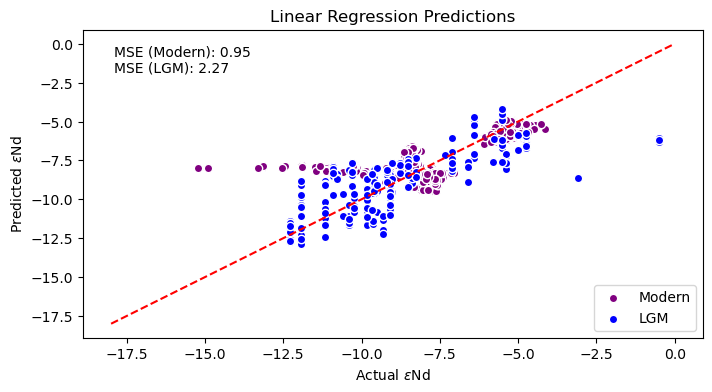

In [7]:
# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the first scatter plot
ax.scatter(mod_y_test, mod_y_pred, color='purple', edgecolor='white', label='Modern')
ax.plot([-18, 0], [-18, 0], 'r--')

# Plot the second scatter plot
ax.scatter(LGM_y_test, LGM_y_pred, color='blue', edgecolor='white', label='LGM')

# Set labels and title
ax.set_ylabel('Predicted ' r'$\epsilon$' 'Nd')
ax.set_xlabel('Actual ' r'$\epsilon$' 'Nd')
ax.set_title('Linear Regression Predictions')

# Calculate and print the MSE for the first plot
mse_mod = mean_squared_error(mod_y_test, mod_y_pred)
ax.text(0.05, 0.95, f"MSE (Modern): {mse_mod:.2f}", transform=ax.transAxes, ha='left', va='top')

# Calculate and print the MSE for the second plot
mse_LGM = mean_squared_error(LGM_y_test, LGM_y_pred)
ax.text(0.05, 0.90, f"MSE (LGM): {mse_LGM:.2f}", transform=ax.transAxes, ha='left', va='top')

# Add a legend
ax.legend(loc='lower right')
# Show the combined plot
plt.show()


In [8]:
## Hyperparameter Tuning

from xgboost import XGBRegressor
boosting_iterations = [2, 10, 25, 50, 100, 250, 500, 1000]

# Initialize lists to store training and validation errors
mod_train_errors = []
mod_val_errors = []

LGM_train_errors = []
LGM_val_errors = []

# Train the boosted regression tree for each number of iterations
for n in boosting_iterations:
    mod_bst = XGBRegressor(n_estimators=n, learning_rate=0.4, eval_metric='rmse')
    bst = mod_bst.fit(mod_X_train, mod_y_train, eval_set=[(mod_X_val, mod_y_val)])
    
    # Calculate training and validation errors
    mod_train_pred = bst.predict(mod_X_train)
    mod_val_pred = bst.predict(mod_X_val)
    mod_train_error = sk.metrics.mean_squared_error(mod_y_train, mod_train_pred)
    mod_val_error = sk.metrics.mean_squared_error(mod_y_val, mod_val_pred)
    
    # Append errors to the lists
    mod_train_errors.append(mod_train_error)
    mod_val_errors.append(mod_val_error)

BI_mod_train_errors = mod_train_errors
BI_mod_val_errors = mod_val_errors

for n in boosting_iterations:
    LGM_bst = XGBRegressor(n_estimators=n, learning_rate=0.4, eval_metric='rmse')
    bst = LGM_bst.fit(LGM_X_train, LGM_y_train, eval_set=[(LGM_X_val, LGM_y_val)])
    
    # Calculate training and validation errors
    LGM_train_pred = bst.predict(LGM_X_train)
    LGM_val_pred = bst.predict(LGM_X_val)
    LGM_train_error = sk.metrics.mean_squared_error(LGM_y_train, LGM_train_pred)
    LGM_val_error = sk.metrics.mean_squared_error(LGM_y_val, LGM_val_pred)
    
    # Append errors to the lists
    LGM_train_errors.append(LGM_train_error)
    LGM_val_errors.append(LGM_val_error)

BI_LGM_train_errors = LGM_train_errors
BI_LGM_val_errors = LGM_val_errors


learning_rate = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Initialize lists to store training and validation errors
mod_train_errors = []
mod_val_errors = []

LGM_train_errors = []
LGM_val_errors = []

# Train the boosted regression tree for each number of iterations
for n in learning_rate:
    mod_bst = XGBRegressor(n_estimators=10, learning_rate=n, eval_metric='rmse')
    bst = mod_bst.fit(mod_X_train, mod_y_train, eval_set=[(mod_X_val, mod_y_val)])
    
    # Calculate training and validation errors
    mod_train_pred = bst.predict(mod_X_train)
    mod_val_pred = bst.predict(mod_X_val)
    mod_train_error = sk.metrics.mean_squared_error(mod_y_train, mod_train_pred)
    mod_val_error = sk.metrics.mean_squared_error(mod_y_val, mod_val_pred)
    
    # Append errors to the lists
    mod_train_errors.append(mod_train_error)
    mod_val_errors.append(mod_val_error)

LR_mod_train_errors = mod_train_errors
LR_mod_val_errors = mod_val_errors

for n in learning_rate:
    LGM_bst = XGBRegressor(n_estimators=25, learning_rate=n, eval_metric='rmse')
    bst = LGM_bst.fit(LGM_X_train, LGM_y_train, eval_set=[(LGM_X_val, LGM_y_val)])
    
    # Calculate training and validation errors
    LGM_train_pred = bst.predict(LGM_X_train)
    LGM_val_pred = bst.predict(LGM_X_val)
    LGM_train_error = sk.metrics.mean_squared_error(LGM_y_train, LGM_train_pred)
    LGM_val_error = sk.metrics.mean_squared_error(LGM_y_val, LGM_val_pred)
    
    # Append errors to the lists
    LGM_train_errors.append(LGM_train_error)
    LGM_val_errors.append(LGM_val_error)

LR_LGM_train_errors = LGM_train_errors
LR_LGM_val_errors = LGM_val_errors



[0]	validation_0-rmse:4.64671
[1]	validation_0-rmse:2.79726
[0]	validation_0-rmse:4.64671
[1]	validation_0-rmse:2.79726
[2]	validation_0-rmse:1.69096
[3]	validation_0-rmse:1.03613
[4]	validation_0-rmse:0.65673
[5]	validation_0-rmse:0.45201
[6]	validation_0-rmse:0.35086
[7]	validation_0-rmse:0.31044
[8]	validation_0-rmse:0.29459
[9]	validation_0-rmse:0.28751
[0]	validation_0-rmse:4.64671
[1]	validation_0-rmse:2.79726
[2]	validation_0-rmse:1.69096
[3]	validation_0-rmse:1.03613
[4]	validation_0-rmse:0.65673
[5]	validation_0-rmse:0.45201
[6]	validation_0-rmse:0.35086
[7]	validation_0-rmse:0.31044
[8]	validation_0-rmse:0.29459
[9]	validation_0-rmse:0.28751
[10]	validation_0-rmse:0.28599
[11]	validation_0-rmse:0.28788
[12]	validation_0-rmse:0.28714
[13]	validation_0-rmse:0.28891
[14]	validation_0-rmse:0.28906
[15]	validation_0-rmse:0.28896
[16]	validation_0-rmse:0.28921
[17]	validation_0-rmse:0.28943
[18]	validation_0-rmse:0.29019
[19]	validation_0-rmse:0.29206
[20]	validation_0-rmse:0.29200

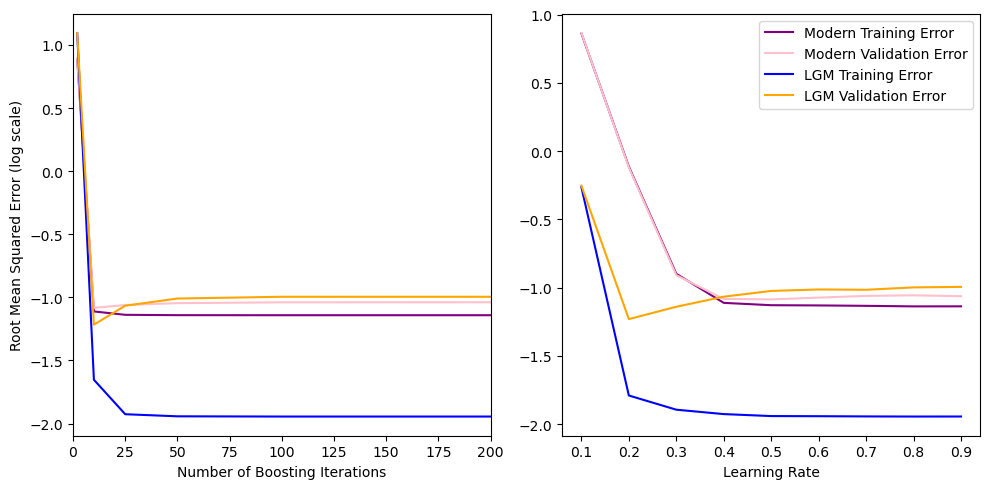

In [9]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the training and validation errors for boosting iterations
ax1.plot(boosting_iterations, np.log10(BI_mod_train_errors), label='Modern Training Error', color='purple')
ax1.plot(boosting_iterations, np.log10(BI_mod_val_errors), label='Modern Validation Error', color='pink')
ax1.plot(boosting_iterations, np.log10(BI_LGM_train_errors), label='LGM Training Error', color='blue')
ax1.plot(boosting_iterations, np.log10(BI_LGM_val_errors), label='LGM Validation Error', color='orange')
ax1.set_xlabel('Number of Boosting Iterations')
ax1.set_ylabel('Root Mean Squared Error (log scale)')
ax1.set_xlim([0, 200])

# Plot the training and validation errors for learning rate
ax2.plot(learning_rate, np.log10(LR_mod_train_errors), label='Modern Training Error', color='purple')
ax2.plot(learning_rate, np.log10(LR_mod_val_errors), label='Modern Validation Error', color='pink')
ax2.plot(learning_rate, np.log10(LR_LGM_train_errors), label='LGM Training Error', color='blue')
ax2.plot(learning_rate, np.log10(LR_LGM_val_errors), label='LGM Validation Error', color='orange')
ax2.set_xlabel('Learning Rate')
ax2.fontsize = 10
# Adjust the spacing between subplots
plt.tight_layout()
plt.legend()

# Show the figure
plt.show()

In [15]:
# Modern Boosted Regression Tree

# Split Data
n = 10
mod_bst = XGBRegressor(n_estimators=n, learning_rate=0.2, eval_metric='rmse')
mod_bst = mod_bst.fit(mod_X_train, mod_y_train)

modern_train_pred = mod_bst.predict(mod_X_train) 
modern_train_error = sk.metrics.mean_squared_error(mod_y_train, modern_train_pred)

modern_val_pred = mod_bst.predict(mod_X_val)
modern_val_error = sk.metrics.mean_squared_error(mod_y_val, modern_val_pred)

modern_test_pred = mod_bst.predict(mod_X_test)
modern_test_error = sk.metrics.mean_squared_error(mod_y_test, modern_test_pred)

print("Boosted Modern Train RMSE: ", modern_train_error)
print("Boosted Modern Val RMSE: ", modern_val_error)
print("Boosted Modern Test RMSE: ", modern_test_error)

# Whole Data
M = mod_bst.fit(mod_X, mod_y)
M_pred = M.predict(mod_X)
M_mse = sk.metrics.mean_squared_error(mod_y, M_pred)
print("Whole Boosted Modern RMSE: ", M_mse)


Boosted Modern Train RMSE:  0.7710882592407811
Boosted Modern Val RMSE:  0.7598986004431569
Boosted Modern Test RMSE:  0.6934951128346659
Whole Boosted Modern RMSE:  0.7624338503534426


In [17]:
# LGM Boosted Regression Tree
n_estimators = 24

LGM_bst = XGBRegressor(n_estimators=n_estimators, learning_rate=0.2, eval_metric='rmse')
LGM_bst = LGM_bst.fit(LGM_X_train, LGM_y_train, eval_set=[(LGM_X_val, LGM_y_val)], verbose=False)

LGM_train_pred = LGM_bst.predict(LGM_X_train)
LGM_train_error = sk.metrics.mean_squared_error(LGM_y_train, LGM_train_pred)

LGM_val_pred = LGM_bst.predict(LGM_X_val)
LGM_val_error = sk.metrics.mean_squared_error(LGM_y_val, LGM_val_pred)

LGM_test_pred = LGM_bst.predict(LGM_X_test)
LGM_test_error = sk.metrics.mean_squared_error(LGM_y_test, LGM_test_pred)

print("Boosted LGM Train RMSE: ", LGM_train_error)
print("Boosted LGM Val RMSE: ", LGM_val_error)
print("Boosted LGM Test RMSE: ", LGM_test_error)

L = LGM_bst.fit(LGM_X, LGM_y, eval_set=[(LGM_X_val, LGM_y_val)], verbose=False)
L_pred = L.predict(LGM_X)
L_mse = sk.metrics.mean_squared_error(LGM_y, L_pred)
print("Boosted LGM RMSE: ", L_mse)

Boosted LGM Train RMSE:  0.017354991246310174
Boosted LGM Val RMSE:  0.058904233972444195
Boosted LGM Test RMSE:  0.04136137202300882
Boosted LGM RMSE:  0.02376146482251227


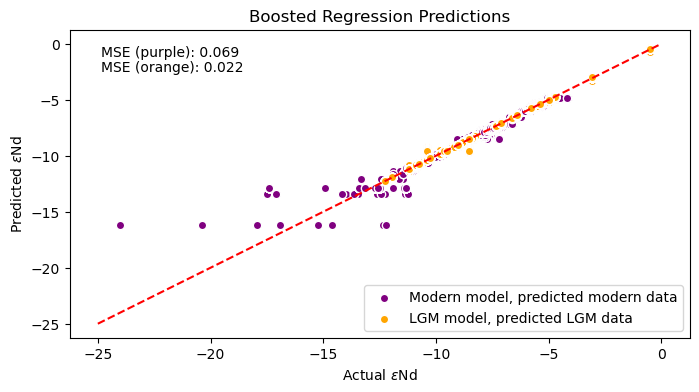

In [12]:
# Create a figure
fig, ax = plt.subplots(figsize=(8, 4))

ax.scatter(mod_y, M_pred, color='purple', edgecolor='white', label='Modern model, predicted modern data')
ax.scatter(LGM_y, L_pred, color='orange', edgecolor='white', label='LGM model, predicted LGM data')
ax.plot([-25, 0], [-25, 0], 'r--')

# Set labels and title
ax.set_ylabel('Predicted ' r'$\epsilon$' 'Nd')
ax.set_xlabel('Actual ' r'$\epsilon$' 'Nd')
ax.set_title('Boosted Regression Predictions')

# Calculate and print the MSE for the first plot
mse_mod = mean_squared_error(mod_y_test, modern_test_pred)
ax.text(0.05, 0.95, f"MSE (purple): {M_mse:.3f}", transform=ax.transAxes, ha='left', va='top')

# Calculate and print the MSE for the second plot
mse_LGM = mean_squared_error(LGM_y_test, LGM_test_pred)
ax.text(0.05, 0.90, f"MSE (orange): {L_mse:.3f}", transform=ax.transAxes, ha='left', va='top')

# Add a legend
ax.legend(loc='lower right')
# Show the combined plot
plt.show()

/Users/paigewise/miniconda3/envs/GEOL599_fp_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/paigewise/miniconda3/envs/GEOL599_fp_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/paigewise/miniconda3/envs/GEOL599_fp_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/paigewise/miniconda3/envs/GEOL599_fp_env/lib/python3.11/site-packages/seaborn/_oldcore.py:111

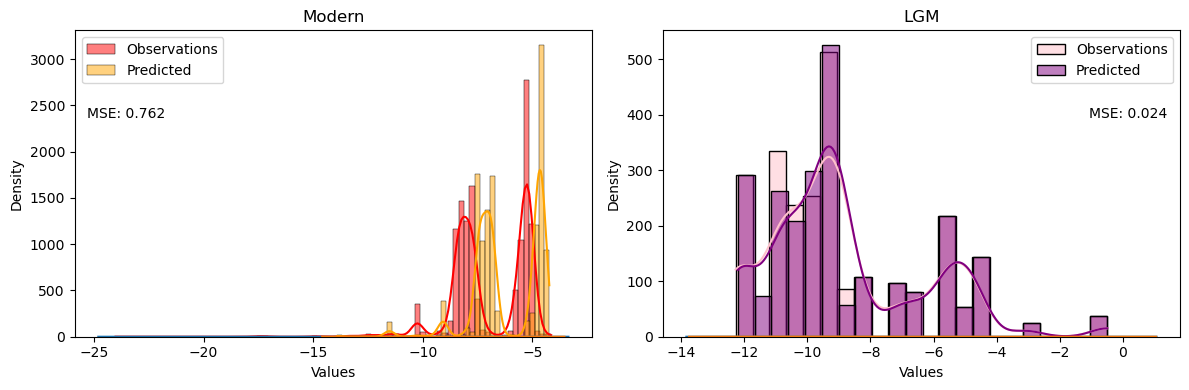

In [90]:
observed_values = mod_y
predicted_values = M_pred

# Calculate the mean squared error
mse_mod = mean_squared_error(observed_values, predicted_values)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the PDF and KDE of observations and predicted values for the first subplot
sns.histplot(data=observed_values, kde=True, ax=ax1, label='Observations', color='red')
sns.kdeplot(data=observed_values, ax=ax1)
sns.histplot(data=predicted_values, kde=True, ax=ax1, label='Predicted', color='orange')
sns.kdeplot(data=predicted_values, ax=ax1)
ax1.set_xlabel('Values')
ax1.set_ylabel('Density')
ax1.title.set_text('Modern')

# Display the MSE on the first plot
ax1.text(0.1, 0.75, f"MSE: {mse_mod:.3f}", transform=ax1.transAxes, ha='center', va='top')

# Add a legend to the first plot
ax1.legend(loc='upper left')

# Plot the PDF and KDE of observations and predicted values for the second subplot
observed_values = LGM_y
predicted_values = L_pred

# Calculate the mean squared error
mse_LGM = mean_squared_error(observed_values, predicted_values)

sns.histplot(data=observed_values, kde=True, ax=ax2, label='Observations', color='pink')
sns.kdeplot(data=observed_values, ax=ax2)
sns.histplot(data=predicted_values, kde=True, ax=ax2, label='Predicted', color='purple')
sns.kdeplot(data=predicted_values, ax=ax2)
ax2.set_xlabel('Values')
ax2.set_ylabel('Density')
ax2.title.set_text('LGM')

# Display the MSE on the second plot
ax2.text(0.9, 0.75, f"MSE: {mse_LGM:.3f}", transform=ax2.transAxes, ha='center', va='top')

# Add a legend to the second plot
ax2.legend(loc='upper right')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


In [13]:
ML = mod_bst.predict(LGM_X)
print("Modern model to LGM data RMSE: ", sk.metrics.mean_squared_error(LGM_y, ML))

LM = LGM_bst.predict(mod_X)
print("LGM model to Modern data RMSE: ", sk.metrics.mean_squared_error(mod_y, LM))

Modern model to LGM data RMSE:  5.701668172885695
LGM model to Modern data RMSE:  5.33204996870543


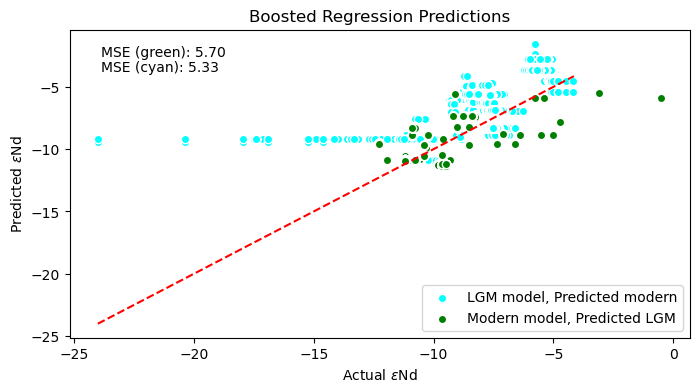

In [92]:
# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(8, 4))

ax.scatter(mod_y, LM, color='cyan', edgecolor='white', label='LGM model, Predicted modern')
ax.scatter(LGM_y, ML, color='green', edgecolor='white', label='Modern model, Predicted LGM')
ax.plot([min(mod_y), max(mod_y)], [min(mod_y), max(mod_y)], 'r--')

# Set labels and title
ax.set_ylabel('Predicted ' r'$\epsilon$' 'Nd')
ax.set_xlabel('Actual ' r'$\epsilon$' 'Nd')
ax.set_title('Boosted Regression Predictions')

# Calculate and print the MSE for the first plot
mse_mod = mean_squared_error(LGM_y, ML)
ax.text(0.05, 0.95, f"MSE (green): {mse_mod:.2f}", transform=ax.transAxes, ha='left', va='top')

# Calculate and print the MSE for the second plot
mse_LGM = mean_squared_error(mod_y, LM)
ax.text(0.05, 0.90, f"MSE (cyan): {mse_LGM:.2f}", transform=ax.transAxes, ha='left', va='top')

# Add a legend
ax.legend(loc='lower right')
# Show the combined plot
plt.show()





/Users/paigewise/miniconda3/envs/GEOL599_fp_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/paigewise/miniconda3/envs/GEOL599_fp_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/paigewise/miniconda3/envs/GEOL599_fp_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/paigewise/miniconda3/envs/GEOL599_fp_env/lib/python3.11/site-packages/seaborn/_oldcore.py:111

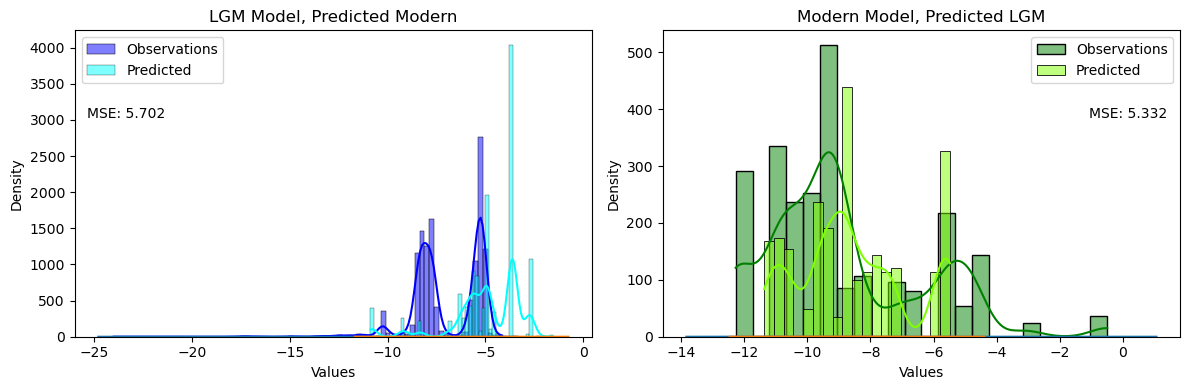

In [93]:
observed_values = mod_y
predicted_values = LM

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the PDF and KDE of observations and predicted values for the first subplot
sns.histplot(data=observed_values, kde=True, ax=ax1, label='Observations', color='blue')
sns.kdeplot(data=observed_values, ax=ax1)
sns.histplot(data=predicted_values, kde=True, ax=ax1, label='Predicted', color='cyan')
sns.kdeplot(data=predicted_values, ax=ax1)
ax1.text(0.1, 0.75, f"MSE: {mse_mod:.3f}", transform=ax1.transAxes, ha='center', va='top')
ax1.set_xlabel('Values')
ax1.set_ylabel('Density')
ax1.title.set_text('LGM Model, Predicted Modern')    
ax1.legend()

observed_values = LGM_y
predicted_values = ML
# Plot the PDF and KDE of observations and predicted values for the second subplot
sns.histplot(data=observed_values, kde=True, ax=ax2, label='Observations', color='green')
sns.kdeplot(data=observed_values, ax=ax2)
sns.histplot(data=predicted_values, kde=True, ax=ax2, label='Predicted',color = 'chartreuse')
sns.kdeplot(data=predicted_values, ax=ax2)
ax2.text(0.9, 0.75, f"MSE: {mse_LGM:.3f}", transform=ax2.transAxes, ha='center', va='top')
ax2.set_xlabel('Values')
ax2.set_ylabel('Density')
ax2.title.set_text('Modern Model, Predicted LGM')
ax2.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()
